In [2]:
# Import required libraries
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
# Load dataset
file_path = "C:/Users/seshi/Downloads/supply_chain_data.csv"
data = pd.read_csv(file_path)

# Display the first few rows for verification
print(data.head())

  Product type   SKU      Price  Availability  Number of products sold  \
0     haircare  SKU0  69.808006            55                      802   
1     skincare  SKU1  14.843523            95                      736   
2     haircare  SKU2  11.319683            34                        8   
3     skincare  SKU3  61.163343            68                       83   
4     skincare  SKU4   4.805496            26                      871   

   Revenue generated Customer demographics  Stock levels  Lead times  \
0        8661.996792            Non-binary            58           7   
1        7460.900065                Female            53          30   
2        9577.749626               Unknown             1          10   
3        7766.836426            Non-binary            23          13   
4        2686.505152            Non-binary             5           3   

   Order quantities  ...  Location Lead time  Production volumes  \
0                96  ...    Mumbai        29          

In [3]:
scaler = MinMaxScaler()
data[['Normalized Lead Times', 'Normalized Defect Rates', 'Normalized Costs']] = scaler.fit_transform(
    data[['Lead times', 'Defect rates', 'Costs']]
)

# Combine factors into a single risk score
data['Delay Risk'] = (
    data['Normalized Lead Times'] * 0.4 +  # Assign weights based on importance
    data['Normalized Defect Rates'] * 0.4 +
    data['Normalized Costs'] * 0.2
)

In [4]:
# --- Inventory Clustering ---# Features for clustering
clustering_features = data[['Stock levels', 'Defect rates', 'Revenue generated']]
kmeans = KMeans(n_clusters=3, random_state=42)
data['Inventory Cluster'] = kmeans.fit_predict(clustering_features)


C:\Users\seshi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\seshi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [5]:
# Adjust clusters for cities with issues
for city in data['Location'].unique():
    city_mode = data[data['Location'] == city]['Inventory Cluster'].mode()[0]
    data.loc[data['Location'] == city, 'Inventory Cluster'] = city_mode

In [6]:
# --- Predictive Modeling for Lead Time ---

In [7]:
# Prepare features and target for lead time prediction
X_lead = pd.get_dummies(data[['Manufacturing costs', 'Production volumes', 'Transportation modes']], drop_first=True)
y_lead = data['Lead times']

# Train-test split
X_train_lead, X_test_lead, y_train_lead, y_test_lead = train_test_split(X_lead, y_lead, test_size=0.2, random_state=42)

# Train regression model
regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train_lead, y_train_lead)

# Predict lead time for the entire dataset
data['Predicted Lead Time'] = regressor.predict(X_lead)

# Evaluate the model
mse_lead = mean_squared_error(y_test_lead, regressor.predict(X_test_lead))
print("Mean Squared Error for Lead Time Prediction:", mse_lead)

# Verify column creation
print(data[['Lead times', 'Predicted Lead Time']].head())


Mean Squared Error for Lead Time Prediction: 101.42438
   Lead times  Predicted Lead Time
0           7                16.16
1          30                25.85
2          10                12.19
3          13                13.04
4           3                11.97


In [8]:
# --- Predictive Modeling for Delay Risk ---

In [9]:
# Features and target for regression
X_delay = pd.get_dummies(data[['Lead times', 'Manufacturing costs', 'Defect rates', 'Transportation modes']], drop_first=True)
y_delay = data['Delay Risk']

# Train-test split
X_train_delay, X_test_delay, y_train_delay, y_test_delay = train_test_split(X_delay, y_delay, test_size=0.2, random_state=42)

# Train regression model for delay risk
delay_risk_model = RandomForestRegressor(random_state=42)
delay_risk_model.fit(X_train_delay, y_train_delay)

# Predict and evaluate
data['Predicted Delay Risk'] = delay_risk_model.predict(X_delay)
mse_delay = mean_squared_error(y_test_delay, delay_risk_model.predict(X_test_delay))
print("Mean Squared Error for Delay Risk Prediction:", mse_delay)

Mean Squared Error for Delay Risk Prediction: 0.004636090522148162


In [10]:
# Prepare features and target for defect risk classification
X_class = pd.get_dummies(data[['Manufacturing costs', 'Production volumes', 'Inspection results']], drop_first=True)
y_class = (data['Defect rates'] > 0.5).astype(int)  # Binary classification: High vs. Low Defect Risk

# Train-test split
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

# Train classification model
classifier = LogisticRegression(random_state=42)
classifier.fit(X_train_class, y_train_class)

# Predict defect risk for the entire dataset
data['Defect Risk Prediction'] = classifier.predict(X_class)

# Evaluate the model
accuracy = accuracy_score(y_test_class, classifier.predict(X_test_class))
print("Accuracy for Defect Risk Classification:", accuracy)
print("\nClassification Report:\n", classification_report(y_test_class, classifier.predict(X_test_class)))

# Verify column creation
print(data[['Defect rates', 'Defect Risk Prediction']].head())

Accuracy for Defect Risk Classification: 0.95

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.95      1.00      0.97        19

    accuracy                           0.95        20
   macro avg       0.47      0.50      0.49        20
weighted avg       0.90      0.95      0.93        20

   Defect rates  Defect Risk Prediction
0      0.226410                       1
1      4.854068                       1
2      4.580593                       1
3      4.746649                       1
4      3.145580                       1


C:\Users\seshi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\seshi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\seshi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
# Calculate difference between actual and predicted delay risk
data['Delay Risk Difference'] = data['Delay Risk'] - data['Predicted Delay Risk']

In [12]:
# Ensure the necessary features for delay risk prediction exist
X_delay = pd.get_dummies(data[['Lead times', 'Manufacturing costs', 'Defect rates', 'Transportation modes']], drop_first=True)
y_delay = data['Delay Risk']

# Train-test split for delay risk regression
X_train_delay, X_test_delay, y_train_delay, y_test_delay = train_test_split(X_delay, y_delay, test_size=0.2, random_state=42)

# Train regression model for delay risk prediction
delay_risk_model = RandomForestRegressor(random_state=42)
delay_risk_model.fit(X_train_delay, y_train_delay)

# Predict delay risk for the entire dataset
data['Predicted Delay Risk'] = delay_risk_model.predict(X_delay)

# Verify column creation
print(data[['Delay Risk', 'Predicted Delay Risk']].head())

   Delay Risk  Predicted Delay Risk
0    0.118417              0.175819
1    0.882421              0.865724
2    0.503489              0.517451
3    0.583629              0.568090
4    0.465220              0.412566


In [14]:
# --- Optimized Costs ---

In [13]:
# Ensure Predicted Delay Risk exists in the dataset
if 'Predicted Delay Risk' in data.columns:
    # Adjust costs for low-risk scenarios
    data['Optimized Costs'] = np.where(
        data['Predicted Delay Risk'] < 0.5,
        data['Costs'] * 0.9,  # Apply 10% reduction
        data['Costs']
    )
    print("Optimized Costs column created successfully.")
else:
    print("Error: 'Predicted Delay Risk' column is missing.")


Optimized Costs column created successfully.


In [15]:
# Adjust optimized costs for all cities
for city in data['Location'].unique():
    city_mean_cost = data[data['Location'] == city]['Optimized Costs'].mean()
    data.loc[data['Location'] == city, 'Optimized Costs'] = city_mean_cost

In [16]:
# --- Feature Importance ---

In [17]:
# Feature importance for delay risk
delay_feature_importance = pd.Series(delay_risk_model.feature_importances_, index=X_delay.columns).sort_values(ascending=False)
delay_feature_importance.to_csv("feature_importance_delay_risk.csv")


In [18]:
# Feature importance for lead time
lead_feature_importance = pd.Series(regressor.feature_importances_, index=X_lead.columns).sort_values(ascending=False)
lead_feature_importance.to_csv("feature_importance_lead_times.csv")


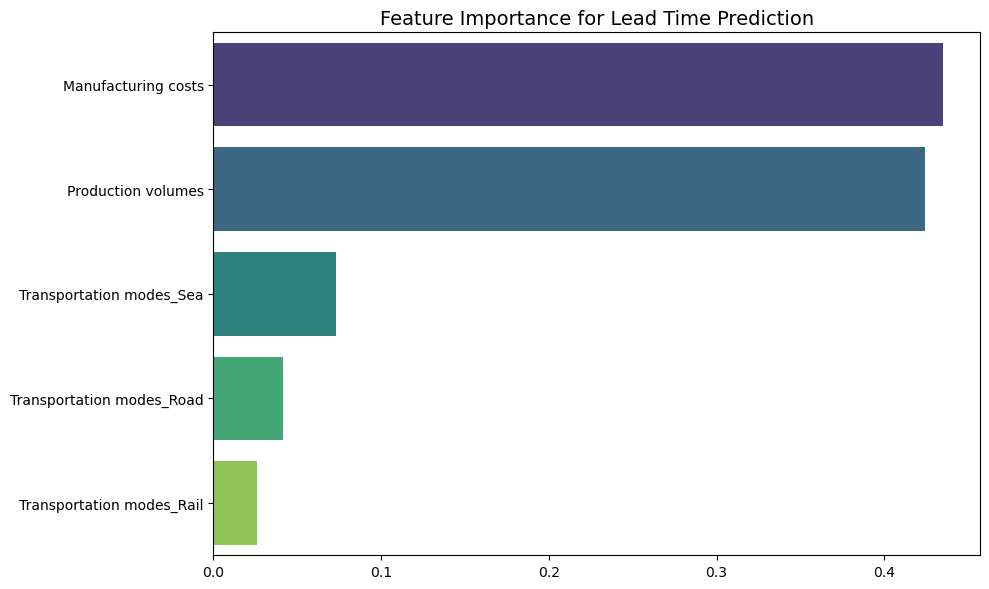

In [19]:
# Plot feature importance for visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=lead_feature_importance, y=lead_feature_importance.index, palette="viridis")
plt.title('Feature Importance for Lead Time Prediction', fontsize=14)
plt.tight_layout()
plt.show()

In [20]:
# Check for missing columns
required_columns = ['Predicted Lead Time', 'Defect Risk Prediction']
missing_columns = [col for col in required_columns if col not in data.columns]
if missing_columns:
    print(f"Missing columns: {missing_columns}")
else:
    print("All required columns are present.")


All required columns are present.


In [21]:
# Group data by city and transportation mode
transport_analysis = data.groupby(['Location', 'Transportation modes']).agg({
    'Costs': 'mean',
    'Lead times': 'mean',
    'Delay Risk': 'mean'
}).reset_index()

# Add a column to rank transportation modes for each city based on Delay Risk and Cost
transport_analysis['Best Mode Rank'] = transport_analysis.groupby('Location')['Delay Risk'].rank(method='first', ascending=True)

# Identify the best mode for each city
best_transportation = transport_analysis[transport_analysis['Best Mode Rank'] == 1].copy()

# Display the best transportation method for each city
print(best_transportation)

     Location Transportation modes       Costs  Lead times  Delay Risk  \
2   Bangalore                 Road  523.351122   15.125000    0.451844   
5     Chennai                 Rail  638.711248   12.000000    0.486271   
10      Delhi                 Road  110.364335    5.000000    0.195765   
15    Kolkata                  Sea  303.927441   11.000000    0.339519   
19     Mumbai                  Sea  364.273847    8.666667    0.330507   

    Best Mode Rank  
2              1.0  
5              1.0  
10             1.0  
15             1.0  
19             1.0  


In [22]:
# --- Save Processed Data for Tableau ---
output_file = "processed_supply_chain_data_final_12.csv"
data.to_csv(output_file, index=False)
print(f"Processed dataset saved to: {output_file}")

Processed dataset saved to: processed_supply_chain_data_final_12.csv


In [23]:
# Save best transportation method data for Tableau
best_transportation_file = "best_transportation_methods.csv"
best_transportation.to_csv(best_transportation_file, index=False)
print(f"Best transportation methods saved to: {best_transportation_file}")

Best transportation methods saved to: best_transportation_methods.csv
